# MNIST Handwritten Digit Generation using GAN

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('Running TF without GPU')
else:
    print(f'Found GPU at {device_name}')

Running TF without GPU


In [2]:
%matplotlib inline

import glob
import imageio
import math
import os
import seaborn as sn
import time

from abc import abstractstaticmethod
from matplotlib import gridspec
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow import keras

sn.set_theme()

In [3]:
NOISE_DIMENSION = 100
TRAIN_SIZE = 60000
TEST_SIZE = 10000
BATCH_SIZE = 128
EPOCHS = 200

EPSILON = 1e-7
N_EXAMPLES = 12
G_LEARNING_RATE = 1e-4
D_LEARNING_RATE = 1e-4

ARCH = 'gan'
METRICS_PATH = f'metrics/{ARCH}/'
OUTPUT_PATH = f'output/{ARCH}/'

!rm -rf $OUTPUT_PATH
!mkdir -p $METRICS_PATH
!mkdir -p $OUTPUT_PATH

In [4]:
assert NOISE_DIMENSION > 0
assert TRAIN_SIZE <= 600000
assert TEST_SIZE <= 10000
assert BATCH_SIZE >= 1
assert EPOCHS >= 1
assert N_EXAMPLES >= 1
assert G_LEARNING_RATE > 0
assert D_LEARNING_RATE > 0
assert EPSILON > 0
assert N_EXAMPLES <= TEST_SIZE

## Base Class

In [5]:
class BaseNetwork(tf.Module):
    def __init__(self):
        super().__init__()

    @tf.Module.with_name_scope
    def __call__(self, input_data, training=False) -> tf.Tensor:
        output_data = input_data
        for layer in self.layers:
            output_data = layer(output_data, training=training)
        return output_data

    @abstractstaticmethod
    def loss() -> tf.Tensor:
        raise NotImplementedError

    @abstractstaticmethod
    def optimizer(*args, **kwargs) -> tf.optimizers.Optimizer:
        raise NotImplementedError

## Generator Network
### Layers
<pre>
<b>Input</b>:  input_size=(128, 1)
<b>Dense</b>:  units=128, activation=ReLU
<b>Dense</b>:  units=256, activation=ReLU
<b>Dense</b>:  units=512, activation=ReLU
<b>Dense</b>:  units=784, activation=tanh, target_shape=(28, 28, 1)
</pre>

### Optimizer
<pre>
<b>Adam</b>:  learning_rate=0.0002
</pre>

### Loss
&#8466;<sub>G</sub>(<i><b>z</b></i>) = <sup>-1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> log <i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>))

### Goal
Find argmin<sub>G</sub> {&#8466;<sub>G</sub>(<i><b>z</b></i>)}

In [6]:
class Generator(BaseNetwork):
    def __init__(self, noise_dimension: int, output_shape: tuple) -> None:
        super().__init__()
        # Network layers
        self.layers = [
            keras.layers.InputLayer(input_shape=(noise_dimension,)),
            keras.layers.Flatten(),
            keras.layers.Dense(units=128),
            keras.layers.ReLU(),
            keras.layers.Dense(units=256),
            keras.layers.ReLU(),
            keras.layers.Dense(units=512),
            keras.layers.ReLU(),
            keras.layers.Dense(units=tf.reduce_prod(output_shape)),
            keras.layers.Reshape(target_shape=output_shape),
            keras.layers.Activation(tf.nn.tanh),
        ]

    @staticmethod
    def optimizer(learning_rate: float) -> tf.optimizers.Optimizer:
        return tf.optimizers.Adam(learning_rate=learning_rate)

    @staticmethod
    @tf.function
    def loss(generated_output):
        loss_i = tf.math.log(generated_output+EPSILON)
        loss = -tf.math.reduce_mean(loss_i)
        return loss

## Discriminator Network
### Layers
<pre>
<b>Input</b>:    input_size=(28, 28, 1)
<b>Dense</b>:    units=512, activation=ReLU
<b>Dropout</b>:  rate=0.4
<b>Dense</b>:    units=512, activation=ReLU
<b>Dropout</b>:  rate=0.3
<b>Dense</b>:    units=512, activation=ReLU
<b>Dropout</b>:  rate=0.3
<b>Dense</b>:    units=256, activation=ReLU
<b>Dropout</b>:  rate=0.2
<b>Dense</b>:    units=128, activation=ReLU
<b>Dropout</b>:  rate=0.1
<b>Dense</b>:    units=64, activation=ReLU
<b>Dense</b>:    units=1, activation=sigmoid
</pre>

### Optimizer
<pre>
<b>Adam</b>:         learning_rate=0.0002
</pre>

### Loss
&#8466;<sub>D</sub>(<i><b>x</b>,<b>z</b></i>) = <sup>-1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> \[log <i>D</i>(<i><b>x</b><sup>(i)</sup></i>) + log (1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))\]

### Goal
Find argmin<sub>D</sub> &#8466;<sub>D</sub>(<i><b>x</b></i>,<i><b>z</b></i>)

In [7]:
class Discriminator(BaseNetwork):
    def __init__(self, input_shape: tuple) -> None:
        super().__init__()
        # Network layers
        self.layers = [
            keras.layers.InputLayer(input_shape=input_shape),
            keras.layers.Flatten(),
            keras.layers.Dense(units=512),
            keras.layers.Dropout(rate=0.3),
            keras.layers.ReLU(),
            keras.layers.Dense(units=512),
            keras.layers.Dropout(rate=0.3),
            keras.layers.ReLU(),
            keras.layers.Dense(units=256),
            keras.layers.Dropout(rate=0.2),
            keras.layers.ReLU(),
            keras.layers.Dense(units=128),
            keras.layers.ReLU(),
            keras.layers.Dense(units=1),
            keras.layers.Activation(tf.nn.sigmoid),
        ]

    @staticmethod
    def optimizer(learning_rate: float):
        return tf.optimizers.Adam(learning_rate=learning_rate)

    @staticmethod
    @tf.function
    def loss(trained_ouput, generated_output) -> tf.Tensor:
        loss_i = tf.math.log(trained_ouput+EPSILON) + tf.math.log1p(-generated_output+EPSILON)
        loss = -tf.math.reduce_mean(loss_i)
        return loss

## Preprocessing
* Import MNIST training images
* Normalize to \[-1, 1\]
* Shuffle and batch dataset

In [8]:
(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()

train_images = tf.dtypes.cast((train_images[:TRAIN_SIZE]-127.5) / 127.5, tf.float32)
train_images = tf.expand_dims(input=train_images, axis=-1)
train_ds = tf.data.Dataset.from_tensor_slices(train_images) \
                          .shuffle(TRAIN_SIZE) \
                          .batch(BATCH_SIZE)

test_images = tf.dtypes.cast((train_images[:TEST_SIZE]-127.5) / 127.5, tf.float32)
test_images = tf.expand_dims(input=test_images, axis=-1)

### Initialize Generator and Discriminator

In [9]:
generator = Generator(noise_dimension=NOISE_DIMENSION, output_shape=(train_images.shape[1:]))
generator_optimizer = generator.optimizer(G_LEARNING_RATE)

discriminator = Discriminator(input_shape=(train_images.shape[1:]))
discriminator_optimizer = discriminator.optimizer(D_LEARNING_RATE)

In [10]:
fixed_noise = tf.random.normal([N_EXAMPLES, NOISE_DIMENSION])
metric_names = ['g_loss', 'd_loss', 'real_acc', 'fake_acc']
batch_history = { name: [] for name in metric_names }
epoch_history = { name: [] for name in metric_names[2:] }

In [11]:
def record_sample(generator: Generator, epoch: int, save: bool=True, show=True):
    fixed_predictions = generator(fixed_noise)
    random_predictions = generator(tf.random.normal(fixed_noise.shape))

    titles = ['Fixed Noise Samples', 'Variational Noise Samples']
    data = [fixed_predictions, random_predictions]

    f = plt.figure(figsize=(8, 4))
    f.suptitle('GAN Output')
    outer = gridspec.GridSpec(1, 2)

    for i in range(2):
        inner = gridspec.GridSpecFromSubplotSpec(int(math.sqrt(N_EXAMPLES)), int(math.sqrt(N_EXAMPLES)), subplot_spec=outer[i])
        predictions = data[i]
        for j in range(predictions.shape[0]):
            ax = plt.Subplot(f, inner[j])
            ax.imshow(predictions[j]*127.5 + 127.5, cmap=plt.cm.gray)
            ax.axis('off')
            if j == int(math.sqrt(N_EXAMPLES)) // 2:
                ax.set_title(titles[i])
            f.add_subplot(ax)

    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'epoch_{:04d}.png'.format(epoch)))
    if show:
        plt.show()
    plt.close()

### Accuracy

In [12]:
def real_accuracy(real_output) -> tf.Tensor:
    # Trained images fed into D have output 1 
    real_acc = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(tf.math.round(real_output), 1.), tf.float32))
    return real_acc

def accuracy(real_output, fake_output) -> tuple:
    # Images from G's noisy distribution should have output 0 from D
    correct_fake_output = tf.zeros_like(fake_output)
    fake_acc = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(tf.math.round(fake_output), 0.), tf.float32))

    return real_accuracy(real_output), fake_acc

## GAN Algorithm
<pre>
<b>for</b> number of training iterations <b>do</b>
  <b>for</b> k steps <b>do</b>
     • Sample minibatch of <i>m</i> noise samples {<i><b>z</b><sup>(1)</sup>, ..., <b>z</b><sup>(m)</sup></i>} from noise prior <i>p<sub>g</sub>(<b>z</b>)</i>.
     • Sample minibatch of <i>m</i> examples {<i><b>x</b><sup>(1)</sup>, ..., <b>x</b><sup>(m)</sup></i>} from data generating distribution <i>p<sub>data</sub>(<b>x</b>)</i>.
     • Update the discriminator by <u>ascending</u> its stochastic gradient:
       <center>&Del;<sub>&theta;<sub>d</sub></sub> <sup>1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> [log <i>D</i>(<i><b>x</b><sup>(i)</sup></i>) + log(1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))]</center>
  <b>end for</b>
  • Sample minibatch of <i>m</i> noise samples {<i><b>z</b><sup>(1)</sup>, ..., <b>z</b><sup>(m)</sup></i>} from noise prior <i>p<sub>g</sub>(<b>z</b>)</i>.
  • Update the generator by <u>descending</u> its stochastic gradient:
  <center>&Del;<sub>&theta;<sub>d</sub></sub> <sup>1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> log(1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))</center>
<b>end for</b>
</pre>

Source: https://arxiv.org/pdf/1406.2661.pdf

In [13]:
record_sample(generator, 0, show=False)
steps_per_epoch = train_images.shape[0] // BATCH_SIZE

for epoch in range(1, EPOCHS+1):
    print(f'\nepoch {epoch}/{EPOCHS}')
    progress_bar = keras.utils.Progbar(steps_per_epoch, stateful_metrics=metric_names)

    for i, image_batch in enumerate(train_ds):

        num_samples = image_batch.shape[0]
        noise = tf.random.normal([num_samples, NOISE_DIMENSION])

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            # Train G on noise
            generated_images = generator(noise, training=True)
            # Train D on training images
            trained_output = discriminator(image_batch, training=True)
            # Train D on generated images
            generated_output = discriminator(generated_images, training=True)

            # Calculate loss
            g_loss = generator.loss(generated_output)
            d_loss = discriminator.loss(trained_output, generated_output)

        real_acc, fake_acc = accuracy(trained_output, generated_output)

        batch_metrics = {
            'g_loss': g_loss,
            'd_loss': d_loss,
            'real_acc': real_acc,
            'fake_acc': fake_acc,
        }

        # Record loss history
        for metric in batch_history:
            batch_history[metric].append(batch_metrics[metric])
    
        batch_metric_values = batch_metrics.items()
        progress_bar.update(i, values=batch_metric_values)        

        # https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient
        grad_g = g_tape.gradient(g_loss, generator.trainable_variables)
        grad_d = d_tape.gradient(d_loss, discriminator.trainable_variables)

        # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients
        generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))

    for metric in epoch_history:
        epoch_history[metric].append(batch_history[metric][-1])

    progress_bar.update(steps_per_epoch, values=batch_metric_values, finalize=True)

    record_sample(generator, epoch, show=False)


epoch 1/200
468/468 [==============================] - 49s 106ms/step - g_loss: 5.5878 - d_loss: 0.2965 - real_acc: 0.9062 - fake_acc: 0.9792

epoch 2/200
468/468 [==============================] - 50s 107ms/step - g_loss: 11.2064 - d_loss: 0.0330 - real_acc: 0.9896 - fake_acc: 1.0000

epoch 3/200
468/468 [==============================] - 54s 115ms/step - g_loss: 4.2426 - d_loss: 0.1508 - real_acc: 0.9479 - fake_acc: 1.0000

epoch 4/200
468/468 [==============================] - 70s 151ms/step - g_loss: 8.8884 - d_loss: 0.0467 - real_acc: 0.9896 - fake_acc: 1.0000

epoch 5/200
468/468 [==============================] - 93s 199ms/step - g_loss: 4.5293 - d_loss: 0.1438 - real_acc: 0.9479 - fake_acc: 1.0000

epoch 6/200
468/468 [==============================] - 74s 159ms/step - g_loss: 4.6851 - d_loss: 0.0409 - real_acc: 0.9896 - fake_acc: 1.0000

epoch 7/200
468/468 [==============================] - 62s 132ms/step - g_loss: 5.6782 - d_loss: 0.0664 - real_acc: 1.0000 - fake_acc: 0.989


epoch 25/200
468/468 [==============================] - 67s 144ms/step - g_loss: 1.0831 - d_loss: 0.9918 - real_acc: 0.7917 - fake_acc: 0.7604

epoch 26/200
468/468 [==============================] - 69s 147ms/step - g_loss: 1.5422 - d_loss: 0.7937 - real_acc: 0.8333 - fake_acc: 0.7604

epoch 27/200
468/468 [==============================] - 69s 146ms/step - g_loss: 1.1826 - d_loss: 1.0408 - real_acc: 0.6771 - fake_acc: 0.8125

epoch 28/200
468/468 [==============================] - 68s 146ms/step - g_loss: 1.3348 - d_loss: 0.9632 - real_acc: 0.7500 - fake_acc: 0.8125

epoch 29/200
468/468 [==============================] - 67s 143ms/step - g_loss: 1.2618 - d_loss: 1.0857 - real_acc: 0.6146 - fake_acc: 0.7604

epoch 30/200
468/468 [==============================] - 70s 149ms/step - g_loss: 1.2822 - d_loss: 0.9270 - real_acc: 0.6979 - fake_acc: 0.7812

epoch 31/200
468/468 [==============================] - 68s 145ms/step - g_loss: 1.0664 - d_loss: 0.9818 - real_acc: 0.7812 - fake_acc:


epoch 55/200
468/468 [==============================] - 64s 137ms/step - g_loss: 1.0745 - d_loss: 1.1519 - real_acc: 0.5521 - fake_acc: 0.8438

epoch 56/200
468/468 [==============================] - 65s 139ms/step - g_loss: 1.1372 - d_loss: 1.1886 - real_acc: 0.5417 - fake_acc: 0.7917

epoch 57/200
468/468 [==============================] - 64s 138ms/step - g_loss: 1.0875 - d_loss: 1.1468 - real_acc: 0.6146 - fake_acc: 0.7500

epoch 58/200
468/468 [==============================] - 66s 141ms/step - g_loss: 0.9623 - d_loss: 1.1993 - real_acc: 0.6042 - fake_acc: 0.7083

epoch 59/200
468/468 [==============================] - 64s 137ms/step - g_loss: 0.8528 - d_loss: 1.2462 - real_acc: 0.6875 - fake_acc: 0.6042

epoch 60/200
468/468 [==============================] - 67s 142ms/step - g_loss: 0.9283 - d_loss: 1.2810 - real_acc: 0.5312 - fake_acc: 0.6667

epoch 61/200
468/468 [==============================] - 65s 138ms/step - g_loss: 0.8913 - d_loss: 1.2081 - real_acc: 0.6042 - fake_acc:


epoch 85/200
468/468 [==============================] - 75s 159ms/step - g_loss: 0.8194 - d_loss: 1.2849 - real_acc: 0.5417 - fake_acc: 0.6771

epoch 86/200
468/468 [==============================] - 74s 158ms/step - g_loss: 1.0867 - d_loss: 1.2531 - real_acc: 0.4271 - fake_acc: 0.8646

epoch 87/200
468/468 [==============================] - 75s 161ms/step - g_loss: 0.7844 - d_loss: 1.2787 - real_acc: 0.5833 - fake_acc: 0.5833

epoch 88/200
468/468 [==============================] - 75s 161ms/step - g_loss: 0.8198 - d_loss: 1.2582 - real_acc: 0.5938 - fake_acc: 0.6667

epoch 89/200
468/468 [==============================] - 75s 159ms/step - g_loss: 0.8254 - d_loss: 1.3023 - real_acc: 0.6250 - fake_acc: 0.6562

epoch 90/200
468/468 [==============================] - 74s 158ms/step - g_loss: 0.8939 - d_loss: 1.2305 - real_acc: 0.5833 - fake_acc: 0.7292

epoch 91/200
468/468 [==============================] - 74s 158ms/step - g_loss: 0.7701 - d_loss: 1.3321 - real_acc: 0.5521 - fake_acc:


epoch 115/200
468/468 [==============================] - 74s 159ms/step - g_loss: 0.7507 - d_loss: 1.3109 - real_acc: 0.6250 - fake_acc: 0.5729

epoch 116/200
468/468 [==============================] - 77s 164ms/step - g_loss: 0.9433 - d_loss: 1.2927 - real_acc: 0.3750 - fake_acc: 0.8542

epoch 117/200
468/468 [==============================] - 74s 159ms/step - g_loss: 0.7718 - d_loss: 1.2994 - real_acc: 0.6146 - fake_acc: 0.6667

epoch 118/200
468/468 [==============================] - 74s 159ms/step - g_loss: 0.7087 - d_loss: 1.3737 - real_acc: 0.5938 - fake_acc: 0.5312

epoch 119/200
468/468 [==============================] - 74s 159ms/step - g_loss: 0.7067 - d_loss: 1.3708 - real_acc: 0.6042 - fake_acc: 0.5000

epoch 120/200
468/468 [==============================] - 76s 163ms/step - g_loss: 0.8022 - d_loss: 1.3818 - real_acc: 0.4167 - fake_acc: 0.6667

epoch 121/200
468/468 [==============================] - 75s 160ms/step - g_loss: 0.6898 - d_loss: 1.3520 - real_acc: 0.6667 - fa


epoch 145/200
468/468 [==============================] - 70s 149ms/step - g_loss: 0.7651 - d_loss: 1.3329 - real_acc: 0.5208 - fake_acc: 0.6250

epoch 146/200
468/468 [==============================] - 70s 150ms/step - g_loss: 0.7522 - d_loss: 1.3563 - real_acc: 0.5417 - fake_acc: 0.6250

epoch 147/200
468/468 [==============================] - 70s 149ms/step - g_loss: 0.7390 - d_loss: 1.3053 - real_acc: 0.6354 - fake_acc: 0.5938

epoch 148/200
468/468 [==============================] - 69s 147ms/step - g_loss: 0.7462 - d_loss: 1.3797 - real_acc: 0.4271 - fake_acc: 0.6146

epoch 149/200
468/468 [==============================] - 70s 150ms/step - g_loss: 0.7590 - d_loss: 1.2990 - real_acc: 0.6042 - fake_acc: 0.6250

epoch 150/200
468/468 [==============================] - 70s 150ms/step - g_loss: 0.8330 - d_loss: 1.3029 - real_acc: 0.5312 - fake_acc: 0.6875

epoch 151/200
468/468 [==============================] - 70s 149ms/step - g_loss: 0.8847 - d_loss: 1.2517 - real_acc: 0.5625 - fa


epoch 175/200
468/468 [==============================] - 71s 153ms/step - g_loss: 0.8080 - d_loss: 1.3166 - real_acc: 0.5208 - fake_acc: 0.6875

epoch 176/200
468/468 [==============================] - 72s 154ms/step - g_loss: 0.7302 - d_loss: 1.3560 - real_acc: 0.5833 - fake_acc: 0.5729

epoch 177/200
468/468 [==============================] - 72s 154ms/step - g_loss: 0.7818 - d_loss: 1.3574 - real_acc: 0.4167 - fake_acc: 0.6667

epoch 178/200
468/468 [==============================] - 72s 153ms/step - g_loss: 0.8013 - d_loss: 1.3684 - real_acc: 0.4062 - fake_acc: 0.7188

epoch 179/200
468/468 [==============================] - 76s 161ms/step - g_loss: 0.7896 - d_loss: 1.3213 - real_acc: 0.5521 - fake_acc: 0.7083

epoch 180/200
468/468 [==============================] - 71s 153ms/step - g_loss: 0.7340 - d_loss: 1.3793 - real_acc: 0.3750 - fake_acc: 0.5938

epoch 181/200
468/468 [==============================] - 74s 158ms/step - g_loss: 0.7887 - d_loss: 1.2946 - real_acc: 0.5521 - fa

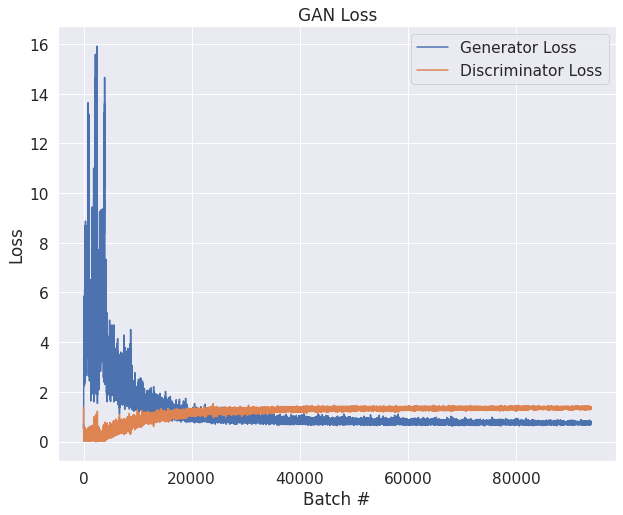

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(batch_history['g_loss'], label='Generator Loss')
plt.plot(batch_history['d_loss'], label='Discriminator Loss')
plt.xlabel('Batch #')
plt.ylabel('Loss')
plt.title('GAN Loss')
plt.legend()
plt.savefig(os.path.join(METRICS_PATH, 'loss.png'))
plt.show()
plt.close()

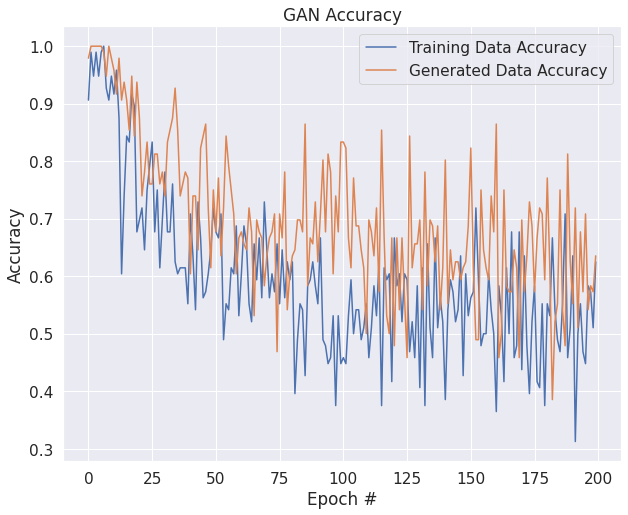

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(epoch_history['real_acc'], label='Training Data Accuracy')
plt.plot(epoch_history['fake_acc'], label='Generated Data Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title('GAN Accuracy')
plt.legend()
plt.savefig(os.path.join(METRICS_PATH, 'accuracy.png'))
plt.show()
plt.close()

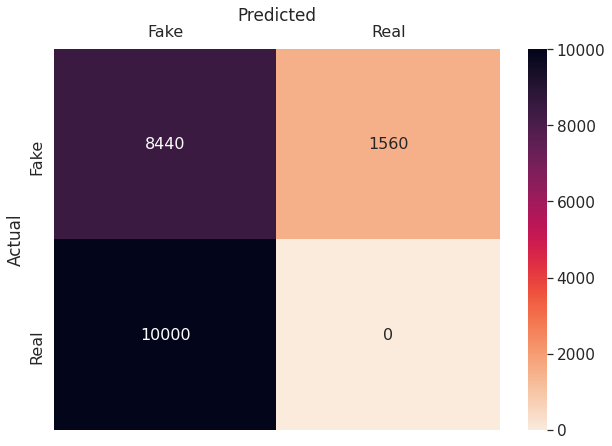

In [21]:
real_test_preds = tf.dtypes.cast(tf.math.round(discriminator(test_images, training=False)), tf.float32)
fake_test_preds = tf.dtypes.cast(tf.math.round(discriminator(generator(tf.random.normal([test_images.shape[0], NOISE_DIMENSION]), training=False), training=False)), tf.float32)
real_labels = tf.ones_like(real_test_preds)
fake_labels = tf.zeros_like(fake_test_preds)
preds = tf.concat([real_test_preds, fake_test_preds], axis=0)
labels = tf.concat([real_labels, fake_labels], axis=0)
preds = tf.squeeze(preds)
labels = tf.squeeze(labels)
named_labels = ['Fake', 'Real']
confusion_matrix = tf.math.confusion_matrix(labels, preds, num_classes=2)
plt.figure(figsize=(10, 7))
ax = plt.axes()
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix, ax=ax, annot=True, annot_kws={'size': 16}, fmt='d', cmap=sn.cm.rocket_r, xticklabels=named_labels, yticklabels=named_labels)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(axis='both', which='major', labelsize=16, labelbottom=False, bottom=False, top=False, labeltop=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.savefig(os.path.join(METRICS_PATH, 'confusion_matrix.png'))
plt.show()
plt.close()

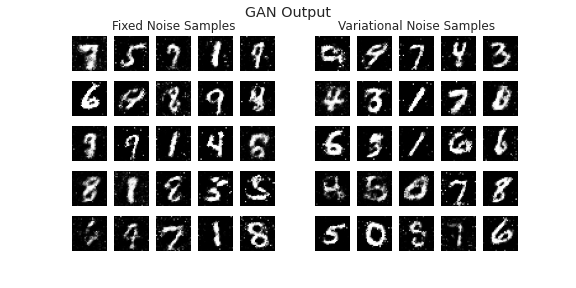

In [17]:
with imageio.get_writer(os.path.join(METRICS_PATH, 'gan.gif'), mode='I') as writer:
    filenames = glob.glob(os.path.join(OUTPUT_PATH, 'epoch*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
final = Image.open(os.path.join(OUTPUT_PATH, 'epoch_{:04d}.png'.format(epoch)))
final.save(os.path.join(METRICS_PATH, 'epoch_{:04d}.png'.format(epoch)))

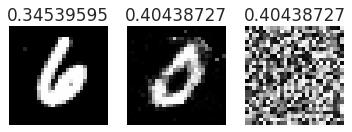

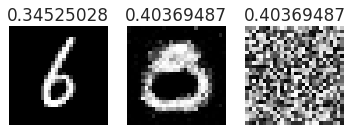

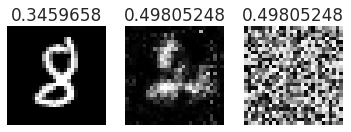

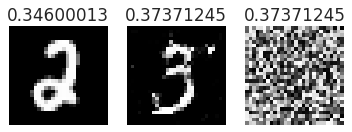

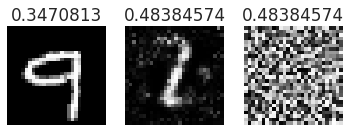

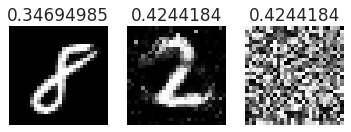

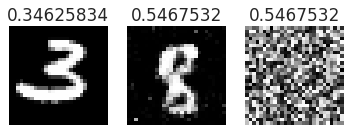

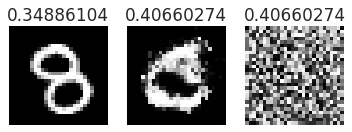

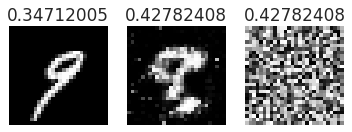

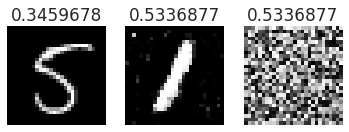

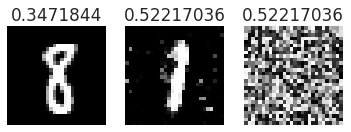

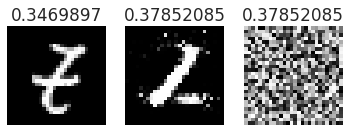

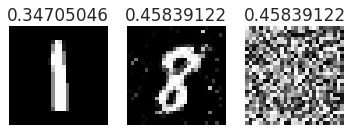

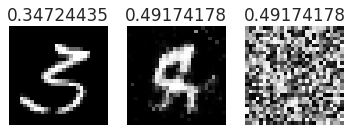

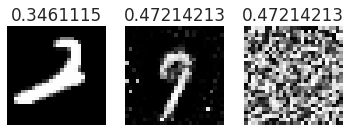

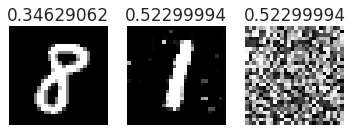

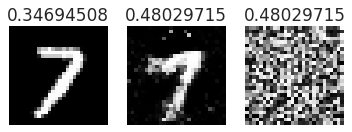

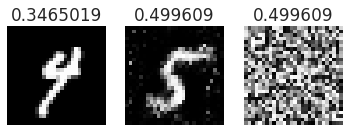

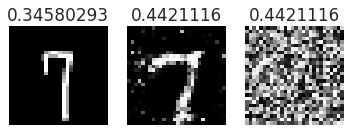

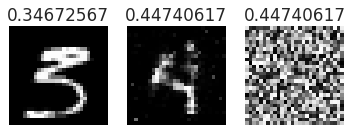

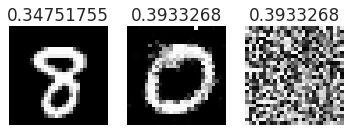

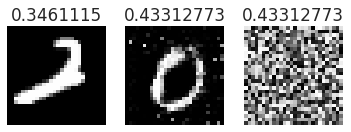

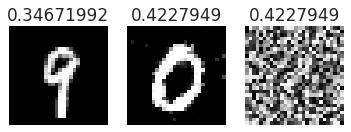

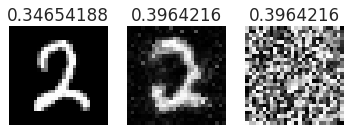

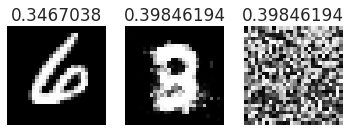

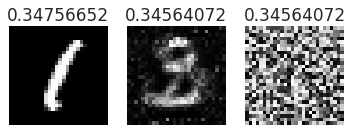

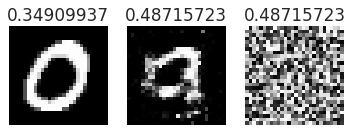

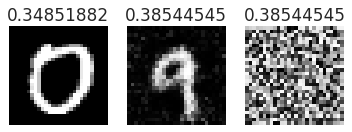

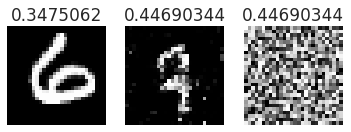

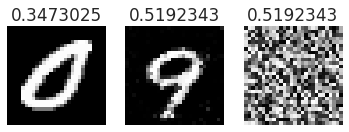

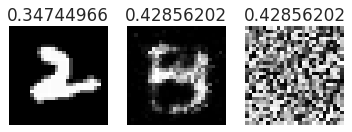

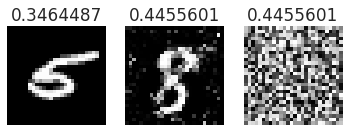

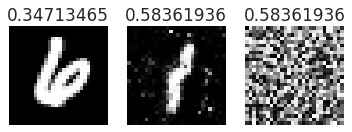

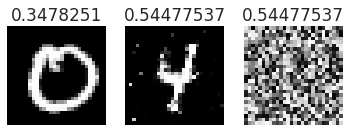

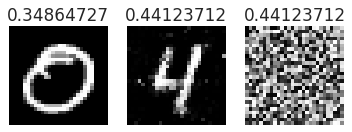

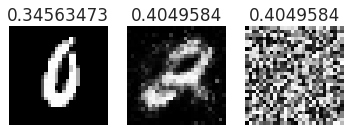

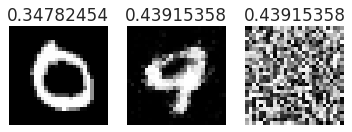

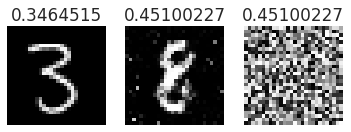

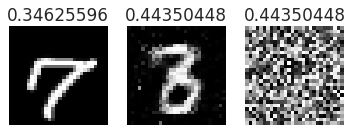

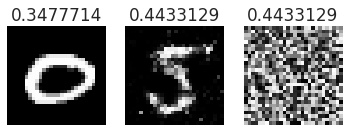

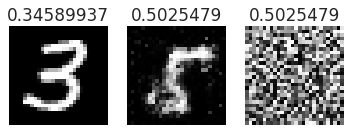

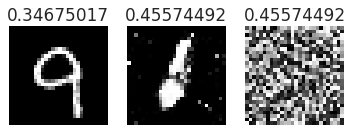

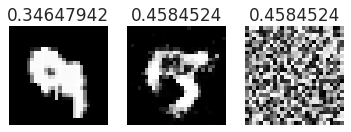

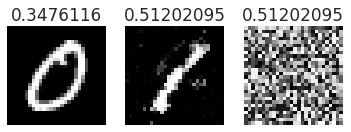

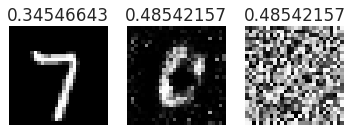

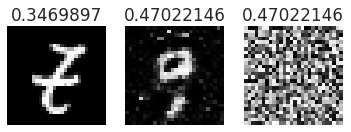

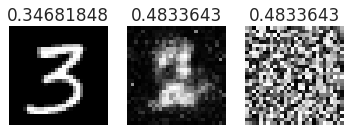

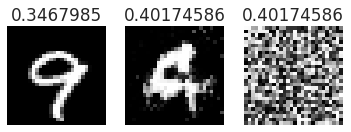

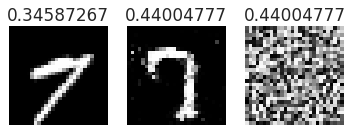

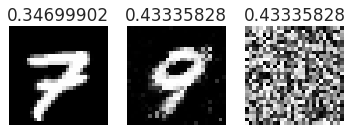

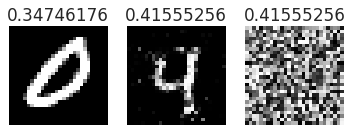

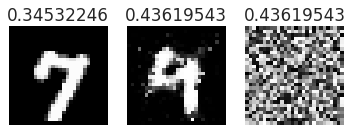

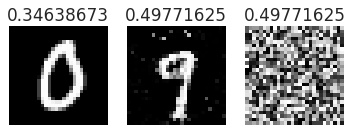

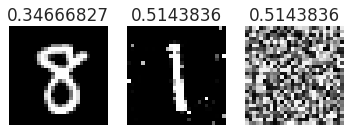

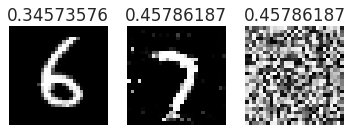

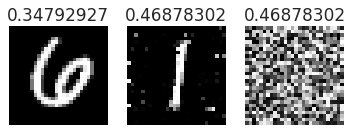

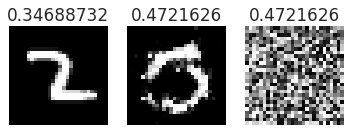

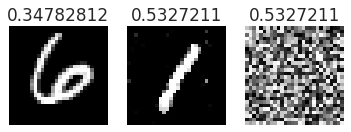

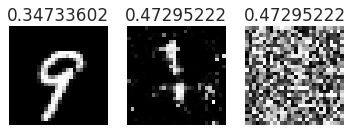

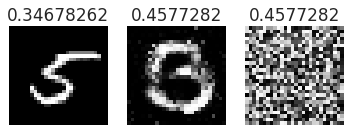

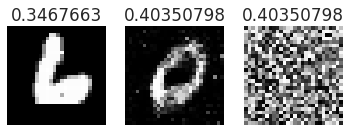

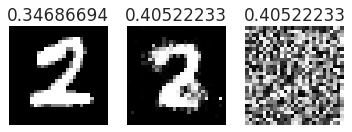

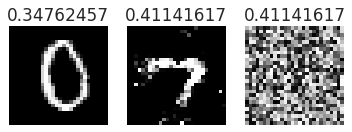

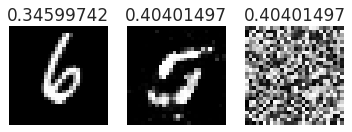

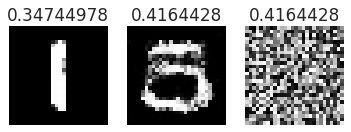

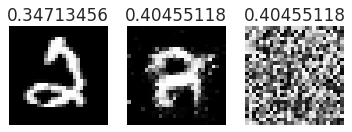

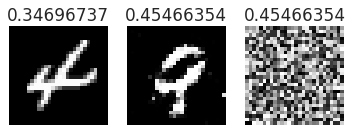

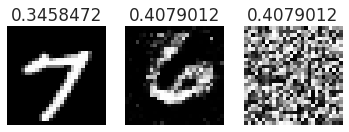

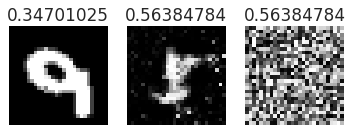

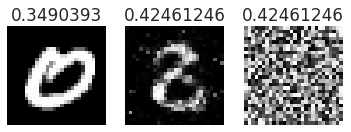

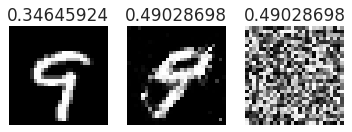

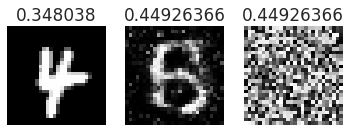

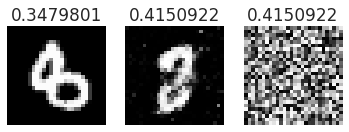

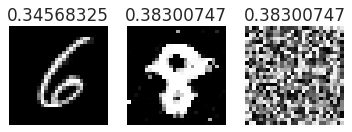

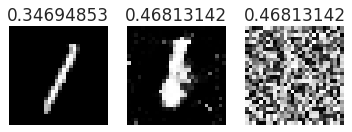

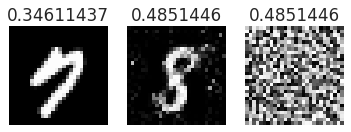

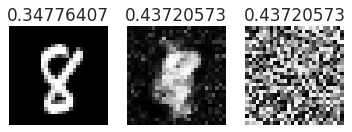

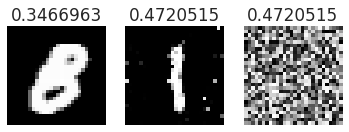

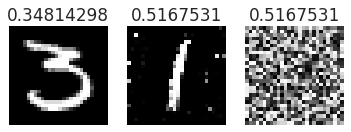

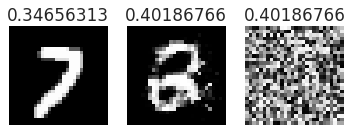

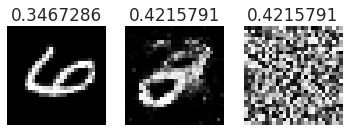

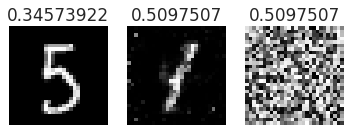

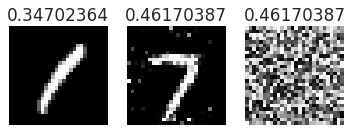

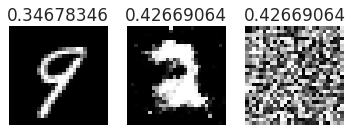

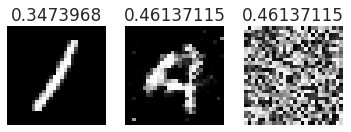

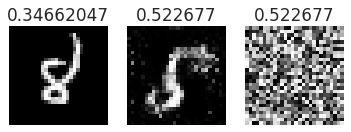

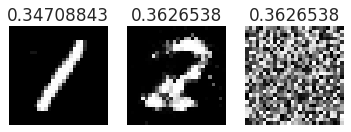

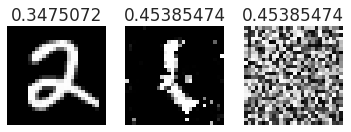

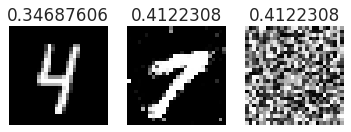

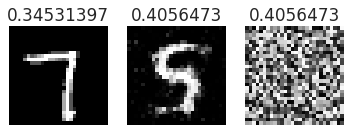

InvalidArgumentError: slice index 10000 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [22]:
for _ in range(100):
    real_test_image = test_images[tf.random.uniform(shape=(), minval=0, maxval=TEST_SIZE+1, dtype=tf.int32), :, :, 0]
    fake_test_image_1 = generator(tf.random.normal([1, NOISE_DIMENSION]), training=False)
    fake_test_image_2 = tf.nn.tanh(tf.random.normal(train_images.shape[1:]))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(real_test_image, cmap=plt.cm.gray)
    ax1.axis('off')
    real_test_image = tf.expand_dims(input=real_test_image, axis=0)
    ax1.set_title(discriminator(real_test_image, training=False).numpy()[0][0])

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(fake_test_image_1[0, :, :, 0], cmap=plt.cm.gray)
    ax2.axis('off')
    ax2.set_title(discriminator(fake_test_image_1, training=False).numpy()[0][0])

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(fake_test_image_2, cmap=plt.cm.gray)
    ax3.axis('off')
    fake_test_image_2 = tf.expand_dims(input=fake_test_image_2, axis=0)
    ax3.set_title(discriminator(fake_test_image_1, training=False).numpy()[0][0])

    plt.show()
    plt.close()

In [23]:
with imageio.get_writer(os.path.join(METRICS_PATH, 'dcgan.gif'), mode='I') as writer:
    filenames = glob.glob(os.path.join(OUTPUT_PATH, 'epoch*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)